![title](afp-logo.png)

# R and Data Science in Finance

In this workbook, we will demonstrate how R and data science can benefit finance professionals. We will do so by showing how a logistic regression model built in R can be used to predict whether a loan will default.

Before we go into building the model let's describe the successful process that is used to address data science problems in business. The process is known as CRISP-DM (Cross-Industry Process for Data Mining). In the process you start with getting understanding about the business problem then you gather the data you need to address the issue. After you collect the data, you cleanse and transform the data to get it ready for modeling. Next, you develop a model and then evaluate the model to see if the model is good enough to use. If it is you deploy the model to production.

Please notice that arrows are bi-directional between many steps. That is because you would often find yourself having to go back and forth between steps. For example, in the *Data Understanding* step, you may realize that it is not in line with what you thought in the *Business Understanding* step so you may need to go back to the *Business Understanding* step to get a better understanding of the problem.

![title](crispdm.jpg)

So let's assume that we already went through the *Business Understanding* and *Data Understanding* phase. So we are going to use R to help us with the remaining steps. In the code below we will load the R packages that will be used to help us prepare and clean the data, build a model, then evaluate the model. 

In [1]:
library(tidyverse)
library(ROCR)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.5
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



Next we load our data into R

In [2]:
setwd("D:/OneDrive - Diesel Analytics/Professional/Clients/FinanceOrganization")
prosperLoanData_Excerpt <- read_csv("prosperLoanData_Excerpt_Revised.csv")

Parsed with column specification:
cols(
  .default = col_integer(),
  ListingKey = col_character(),
  ListingCreationDate = col_datetime(format = ""),
  CreditGrade = col_character(),
  LoanStatus = col_character(),
  ClosedDate = col_datetime(format = ""),
  BorrowerAPR = col_double(),
  BorrowerRate = col_double(),
  LenderYield = col_double(),
  EstimatedEffectiveYield = col_double(),
  EstimatedLoss = col_double(),
  EstimatedReturn = col_double(),
  `ProsperRating (Alpha)` = col_character(),
  BorrowerState = col_character(),
  Occupation = col_character(),
  EmploymentStatus = col_character(),
  IsBorrowerHomeowner = col_logical(),
  CurrentlyInGroup = col_logical(),
  GroupKey = col_character(),
  DateCreditPulled = col_datetime(format = ""),
  FirstRecordedCreditLine = col_datetime(format = "")
  # ... with 24 more columns
)
See spec(...) for full column specifications.


Once we read in the data we transform the data for modeling. This transformation is known as *feature engineering*. In this section we will do transformation such as converting continuous data such as credit scores into categories of *Excellent, Good, Fair, Poor,* and *Bad*. We will apply similar transformation for Delinquencies, bankcard utilization, and other variables. 

In [4]:
prosper_data <-
    prosperLoanData_Excerpt %>%
    filter(!is.na(BankcardUtilization) & !is.na(CreditScoreRangeLower) & !is.na(CreditScoreRangeUpper) & !is.na(DelinquenciesLast7Years)) %>%
    select(ListingKey, LoanStatus, IsBorrowerHomeowner, CreditScoreRangeLower, CreditScoreRangeUpper, 
           DelinquenciesLast7Years, BankcardUtilization, IncomeRange
    ) %>%
    mutate(
        AvgScore = round((CreditScoreRangeLower + CreditScoreRangeUpper)/2,0),
        CreditScoreCategory =
            ifelse(AvgScore >= 750, "Excellent",
            ifelse(AvgScore >= 700 & AvgScore <= 749, "Good",
            ifelse(AvgScore >= 650 & AvgScore <= 699, "Fair",
            ifelse(AvgScore >= 550 & AvgScore <= 649, "Poor",
            ifelse(AvgScore < 550, "Bad", 
            ifelse(is.na(CreditScoreRangeLower) | is.na(CreditScoreRangeUpper),"Unknown","Unknown")))))),
        TerminalStatus = ifelse(LoanStatus == "Completed", 1,0),
        DelinquencyCategory = 
            ifelse(DelinquenciesLast7Years <= 7, "Good",
            ifelse(DelinquenciesLast7Years > 7 & DelinquenciesLast7Years <= 14, "Ok", "Bad")),
        BankcardUtilizationCategory = ifelse(BankcardUtilization > 0.3, "Bad", "Good")
    ) %>%
    select(
        ListingKey, IsBorrowerHomeowner, CreditScoreCategory, BankcardUtilizationCategory, 
        DelinquencyCategory, IncomeRange, TerminalStatus
    ) %>%
    mutate_all(factor)

Next, we will split our data into two data sets. We will split our data into a training data set and testing data set using the code below. The training dataset will be used to train our model. We will check the model we built using the testing data set. We want to ensure that we are using an adequate amount of data to train our model, so we use a randomly chosen data set that represents 80% of our data in our training data set and the remainder in our testing data set.

In [5]:
prosper_traindata <- sample_frac(prosper_data, 0.8)
prosper_testdata <- anti_join(prosper_data, prosper_traindata, by=c("ListingKey", "ListingKey"))

Below we define our logistic regression formula then we build the model. Note how we are able to do so with a relatively small amount of code.

In [6]:
PredictDefaultsFormula <-
    as.formula(
        "TerminalStatus ~ 
            IsBorrowerHomeowner + CreditScoreCategory + BankcardUtilizationCategory + DelinquencyCategory + IncomeRange"
    )

DefaultsModel <- glm(PredictDefaultsFormula, family = binomial, data = prosper_traindata)

We use the summary function to evaluate the model. A critical piece of information that this output gives us is if the coefficients of our variable are significantly different than zero. We can do so in two ways. The first method we can use is by using the p-value of the coefficient via the "Pr(>|z|)" column. If the value in the column is less than 0.05, then it is statistically different from 0. We can also look at the number of "\*" after the p-value score. If there are 1 or more "\*" next to it, then we can conclude that it is statistically different then zero.

In [7]:
summary(DefaultsModel)


Call:
glm(formula = PredictDefaultsFormula, family = binomial, data = prosper_traindata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1977  -1.2997   0.6772   0.9718   1.6203  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.74421    0.12916  -5.762 8.31e-09 ***
IsBorrowerHomeownerTRUE         -0.52813    0.03641 -14.506  < 2e-16 ***
CreditScoreCategoryExcellent     2.15283    0.08702  24.739  < 2e-16 ***
CreditScoreCategoryFair          1.11553    0.07488  14.898  < 2e-16 ***
CreditScoreCategoryGood          1.43833    0.08225  17.487  < 2e-16 ***
CreditScoreCategoryPoor          0.65762    0.07328   8.974  < 2e-16 ***
BankcardUtilizationCategoryGood -0.03170    0.03860  -0.821 0.411474    
DelinquencyCategoryGood          0.18852    0.05150   3.661 0.000252 ***
DelinquencyCategoryOk            0.07920    0.07169   1.105 0.269301    
IncomeRange$1-24,999             0.30476    0.11062

Now that we evaluated the model we want to apply it against the test data that we held back. We do that in the code below via the predict function. We set the "type" argument to "response" so that the "predict" function will return a column of predicted probabilities that are in the same order of the data data that was passed to it. We assign those values a variable named "PredictDefaults". Next add that array of values as a column to the test data that we used. 

In [8]:
PredictDefaults <- predict(DefaultsModel, newdata = prosper_testdata, type = "response")
prosper_testdata <- cbind(prosper_testdata, PredictDefaults)

Finally we evaluate the model to test the model effectiveness using a ROC Curve analysis. We are concerned with the area under the curve. The minimum value that is acceptable is something north of 50% because since our outcome is binary we can guess 50% by flipping a coin. The AUC (Area Under the Curve) in our case is 67%. We need to determine if that is acceptable or not. If it is we will deploy the model. If it is not we will go back to a previous step to make changes until we get the model to perform at a level that is acceptable. 

In [9]:
perf.data <- prediction(prosper_testdata$PredictDefaults, prosper_testdata$TerminalStatus)
perf <- performance(perf.data, measure = "auc")
AUC_Stat <- round(as.numeric(perf@y.values),2)

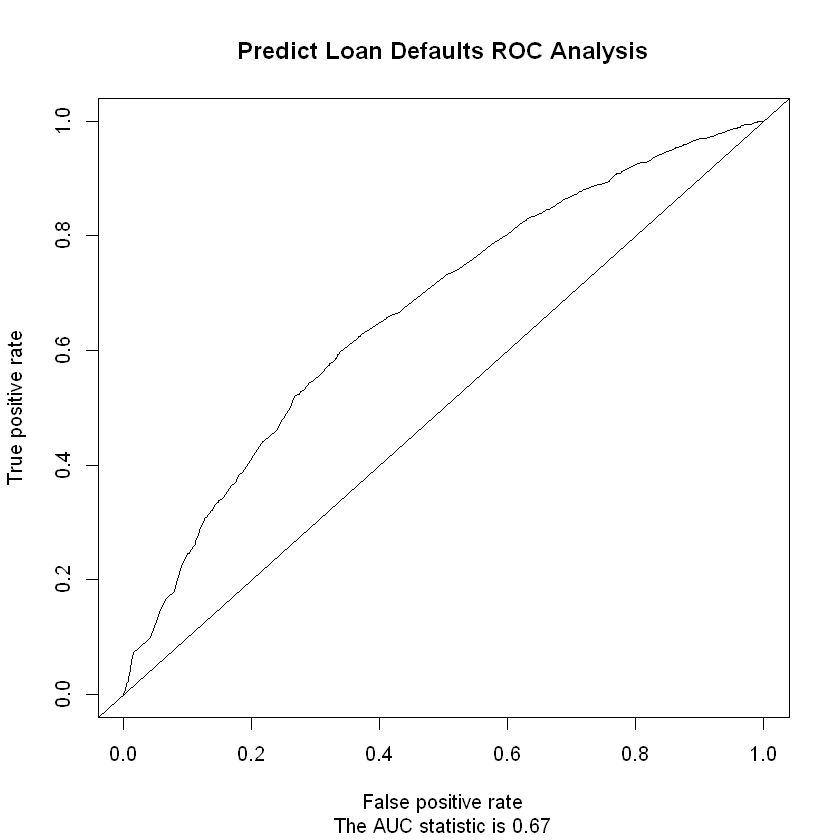

In [10]:
plot.data <- performance(perf.data, "tpr", "fpr")
main_title <- "Predict Loan Defaults ROC Analysis"
sub_title <- paste("The AUC statistic is", AUC_Stat, sep = " ")
plot(plot.data, main = main_title, sub = sub_title)
abline(a = 0, b = 1)